In [1]:
%pylab inline

from PIL import Image
from scipy.ndimage import gaussian_filter
from PYME.simulation.locify import locify
from PYME.LMVis.visHelpers import rendGauss
from PYME.IO.image import ImageBounds

Populating the interactive namespace from numpy and matplotlib


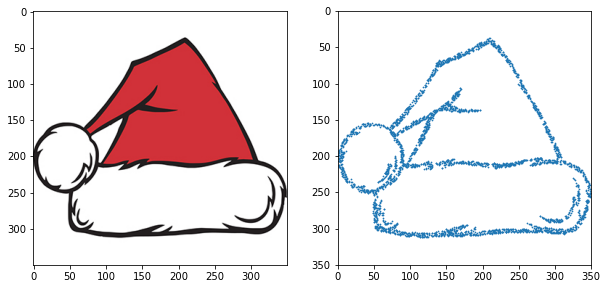

In [2]:
fn = 'santa_hat.jpeg'

# Generate points, scaling factor
with Image.open(fn) as im:
    
    # Load and threshold just the thick black lines
    # in the image
    im_arr = np.array(im)
    im_thresh = np.sum(im_arr,axis=2)<100
    points = np.vstack(locify(im_thresh, pointsPerPixel=0.5)).T
    
    # Plot
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(im)
    axs[1].scatter(points[:,1],points[:,0],s=0.5)
    axs[1].set_xlim([0,im_arr.shape[0]])
    axs[1].set_ylim([0,im_arr.shape[1]])
    axs[1].set_aspect('equal')
    axs[1].invert_yaxis()

In [3]:
# Generate sigma for points
s = 250  # psf width (nm)
mu = 100   # minimum photon count (sCMOS)
bg = 20

lx = np.random.exponential(mu,10*len(points[:,0]))
ly = np.random.exponential(mu,10*len(points[:,1]))
sx = s/2.355/np.sqrt(lx[lx > bg][:len(points[:,0])])
sy = s/2.355/np.sqrt(ly[ly > bg][:len(points[:,1])])

sigma = np.sqrt((sx*sx)+(sy*sy))

In [4]:
# Generate stack of images of rendered Gaussians 
# for each SMLM time point
frame_rate = 24
time_blend_sigma = 1
all_point_dur = frame_rate//4
pixel_size = 100  # nm

# Rescale the image size so the hat is about the size of a cell
scale = 20000/(np.max(points[:,0])-np.min(points[:,0]))
scaled_points = scale*points
lb = int(min(np.min(scaled_points[:,0]),np.min(scaled_points[:,1])))
ub = int(max(np.max(scaled_points[:,0]),np.max(scaled_points[:,1])))
image_bounds = ImageBounds(lb, lb, ub, ub)

lx = int((ub-lb)/pixel_size+0.5)
idxs = np.random.randint(0,points.shape[0],points.shape[0])
chunks = np.cumsum(np.hstack([0,mu*np.exp(-mu*np.arange(points.shape[0])/points.shape[0])])).astype(np.int)
chunks = np.hstack([chunks[chunks<points.shape[0]], points.shape[0]])
ims = np.zeros((chunks.shape[0]+all_point_dur,lx,lx))
for i in range(chunks.shape[0]-1):
    curr_idxs = idxs[chunks[i]:chunks[i+1]]
    curr_points = scaled_points[curr_idxs,:]
    ims[i+all_point_dur] = rendGauss(curr_points[:,0], curr_points[:,1], 
                                     sx[curr_idxs], image_bounds, pixel_size)
    
all_points = rendGauss(scaled_points[:,0], scaled_points[:,1], sx, 
                       image_bounds, pixel_size)
for i in range(all_point_dur//2,all_point_dur):
    ims[i] = all_points

In [5]:
# smooth in z-dir to create on/off effect
ims = gaussian_filter(ims, sigma=(time_blend_sigma, 0, 0), order=0, mode='wrap')

In [6]:
# convert to animated gif
blink_chunk = all_point_dur+time_blend_sigma*time_blend_sigma
ims = 255*(ims-np.min(ims[blink_chunk:]))/(np.max(ims[blink_chunk:])-np.min(ims[blink_chunk:]))
ims[ims > 255] = 255
ims = ims.astype(np.uint8)
imgs = [Image.fromarray(img) for img in ims]
imgs[0].save("santa_hat_smlm.gif", save_all=True, append_images=imgs[1:], 
             duration=ims.shape[0]//frame_rate, loop=0)